In [1]:
# Connecting google drive to colab:

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/MyDrive
%cd gtzan

Mounted at /content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/gtzan


In [2]:
# Importing libraries:

import numpy as np
import librosa
import librosa.display
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.layers import Reshape, GaussianNoise, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization

In [3]:
# Loading the data:

n_mfcc = 50 # Change this for different image sizes
mfcc = []
labels = []

print("Loading audio data and extracting mfcc...")

for dirname, _, filenames in os.walk("genres"):
    print("Currently in:", dirname.split("/")[-1])
    for filename in filenames:
        track, _ = librosa.load(os.path.join('.',dirname, filename))
        mfcc.append(librosa.feature.mfcc(track, n_mfcc = n_mfcc))
        labels.append(filename.split(".")[0])           

print("Total tracks:", len(mfcc))
print("Total labels:", len(labels))

Loading audio data and extracting mfcc...
Currently in: genres
Currently in: classical
Currently in: blues
Currently in: country
Currently in: pop
Currently in: disco
Currently in: hiphop
Currently in: metal
Currently in: rock
Currently in: jazz
Currently in: reggae
Total tracks: 1000
Total labels: 1000


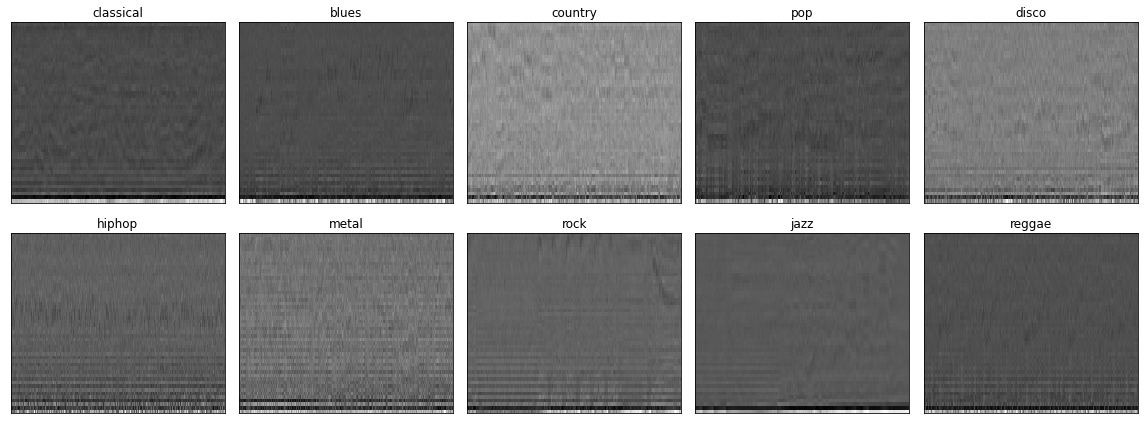

In [4]:
# Plotting one image from each genre:

fig = plt.figure(figsize=(16,6))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(labels[100*i])
    librosa.display.specshow(mfcc[100*i], cmap="gray_r")

plt.tight_layout()
plt.show()    

In [5]:
# Find minimum size of axis 1
# Crop the images to shpape (n_mfcc, min_size)

# Data will be stored in a 2-dimensional array of shape (n_data, n_mfcc * min_size)
# The CNN reshapes the data to the required shape

min_size = 1e6

for image in mfcc:
    if image.shape[1] < min_size:
        min_size=image.shape[1]

print("Minimum width of mfcc images:", min_size)

img_size = (n_mfcc, min_size)

# Making all mfcc images (features) have the same size:

X = []
for image in mfcc:
    cropped_image = image[:, :min_size]
    X.append(cropped_image.reshape(img_size[0]*img_size[1]))

X = np.array(X)
print("Shape of X:", X.shape)

# Scale all data together
# In this way relative intensities in image will remain after scaling
# Previously, all images had a 0 and a 1.

X -= np.min(X)
X /= np.max(X)

# Converting Y (labels) list to an array:

Y = np.array(labels)
print("Shape of Y:", Y.shape)

Minimum width of mfcc images: 1290
Shape of X: (1000, 64500)
Shape of Y: (1000,)


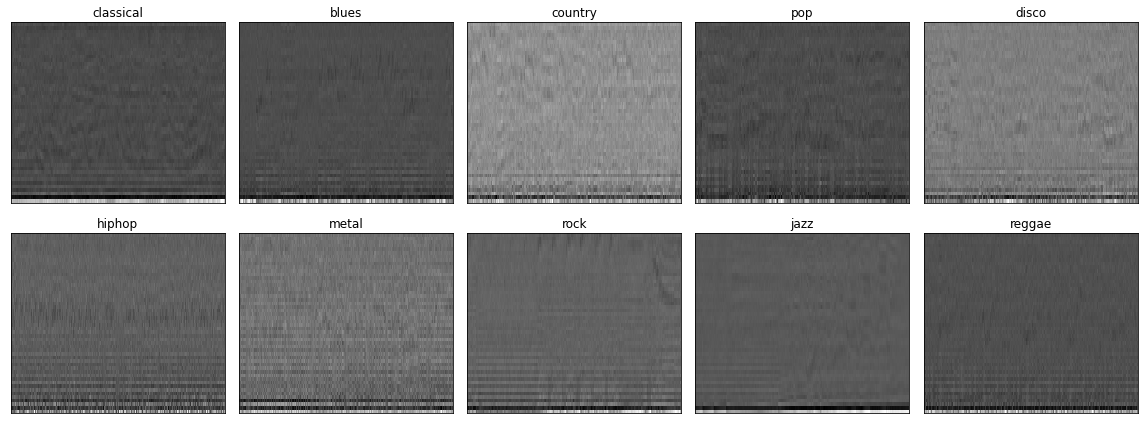

In [6]:
# Plot one image from each genre:

fig = plt.figure(figsize=(16,6))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(labels[100*i])
    librosa.display.specshow(X[100*i,:].reshape(img_size[0],img_size[1]), cmap="gray_r")
    
plt.tight_layout()
plt.show()

In [7]:
# Converting word labels to numerical class labels:

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Defining the number of output classes:

num_classes = len(label_encoder.classes_)

In [8]:
# Splitting data into training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)

In [9]:
ACCURACY_THRESHOLD = 0.95 # if CNN accuracy reaches that number training will stop

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True
        
callbacks = myCallback()

In [10]:
# Building the CNN model:

model = tf.keras.Sequential([
    
    # Preprocessing layers:
    Reshape(target_shape=(img_size[0], img_size[1],1), input_shape=(X_train.shape[1],)),
    GaussianNoise(stddev=0.05),
    
    # First convolution:
    Conv2D(32, kernel_size=(3, 3),activation="leaky_relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    # Second convolution:
    Conv2D(32, kernel_size=(3, 3),activation="leaky_relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    # Third convolution:
    Conv2D(32, kernel_size=(3, 3),activation="leaky_relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    # Fourth convolution:
    Conv2D(32, kernel_size=(3, 3),activation="leaky_relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    # Feature extractor and classifier:
    Flatten(),
    Dense(32, kernel_regularizer="l2",activation='sigmoid'),
    Dropout(0.2),
    Dense(num_classes, kernel_regularizer="l2", activation='softmax')
])

In [11]:
# Compiling the model: 

learning_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-3, decay_steps=1e2, decay_rate=1e-2)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Fitting the model:

model.fit(X_train, y_train, epochs=50, batch_size=4, callbacks=[callbacks])

Epoch 1/50
  4/175 [..............................] - ETA: 3s - loss: 3.3566 - accuracy: 0.1250       

175/175 [==============================] - 16s 18ms/step - loss: 3.0337 - accuracy: 0.0857
Epoch 2/50
175/175 [==============================] - 3s 17ms/step - loss: 2.6619 - accuracy: 0.1014
Epoch 3/50
175/175 [==============================] - 3s 17ms/step - loss: 2.4983 - accuracy: 0.1157
Epoch 4/50
175/175 [==============================] - 3s 17ms/step - loss: 2.3463 - accuracy: 0.1986
Epoch 5/50
175/175 [==============================] - 3s 17ms/step - loss: 2.2718 - accuracy: 0.2414
Epoch 6/50
175/175 [==============================] - 3s 18ms/step - loss: 2.1855 - accuracy: 0.2986
Epoch 7/50
175/175 [==============================] - 3s 17ms/step - loss: 2.1441 - accuracy: 0.3043
Epoch 8/50
175/175 [==============================] - 3s 17ms/step - loss: 2.1050 - accuracy: 0.2986
Epoch 9/50
175/175 [==============================] - 3s 17ms/step - loss: 2.1196 - accuracy: 0.3214
Epoch 10/50
175/175 [==============================] - 3s 17ms/step - loss: 2.0703 - accuracy: 0.3129

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50, 1290, 1)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 50, 1290, 1)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 48, 1288, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 48, 1288, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 644, 32)      0         
 )                                                               
                                                        

In [14]:
model.pop()
model.pop()

In [15]:
# Extracting features from CNN model:

features_train = model.predict(X_train)
features_test = model.predict(X_test)

print(features_train.shape)
print(features_test.shape)

10/10 [==============================] - 0s 32ms/step
(700, 32)
(300, 32)


In [16]:
# PCA:

variance_wanted = .99

pca = PCA()
pca.fit(features_train)

total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

for i in range(pca.n_components_):
    if(total_explained_variance[i]>= variance_wanted):
        n_components=i+1
        print(f"Components needed for 99% variance: {n_components}")
        break

Components needed for 99% variance: 22


In [17]:
# PCA: 

pca = PCA(n_components = n_components)
pca_features_train = pca.fit_transform(features_train)
pca_features_test = pca.transform(features_test)

In [18]:
# This is what we must put in the cv parameter:

cv = StratifiedKFold(n_splits=10)

Train time = 0.0056498050689697266 s
Test time = 0.004839658737182617 s

Accuracy: 0.5066666666666667
Precision: 0.5259733443672323
Recall: 0.5066666666666666
F1 score: 0.5059005015122124


<AxesSubplot:>

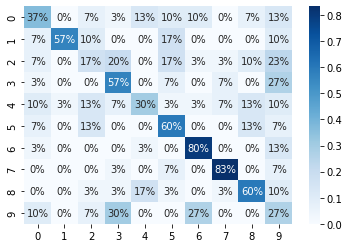

In [19]:
# GNB:

gnb = GaussianNB()
start_time_train = time.time()
gnb.fit(pca_features_train, y_train)
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = gnb.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = gnb.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')

Train time = 0.2073969841003418 s
Test time = 0.016080141067504883 s

Accuracy: 0.5333333333333333
Precision: 0.5437371933908736
Recall: 0.5333333333333333
F1 score: 0.5314832623192094

Οι βέλτιστες υπερπαράμετροι είναι οι εξής: {'n_neighbors': 7}


<AxesSubplot:>

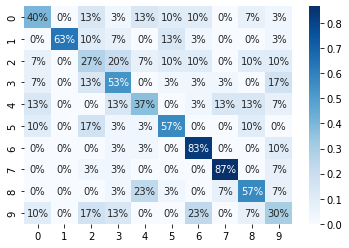

In [20]:
# kNN: 

knn = KNeighborsClassifier()
grid = {"n_neighbors": [3, 5, 7, 9]}

estimator = GridSearchCV(knn, param_grid=grid, cv = cv, scoring = 'accuracy')

start_time_train = time.time()
estimator.fit(pca_features_train, y_train) 
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = estimator.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = estimator.best_estimator_.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

print("\n" + 'Οι βέλτιστες υπερπαράμετροι είναι οι εξής: ' + str(estimator.best_params_))

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')

Train time = 0.789309024810791 s
Test time = 0.005548715591430664 s

Accuracy: 0.54
Precision: 0.5533734596345787
Recall: 0.5399999999999999
F1 score: 0.5306194993795436

Οι βέλτιστες υπερπαράμετροι είναι οι εξής: {'kernel': 'linear'}


<AxesSubplot:>

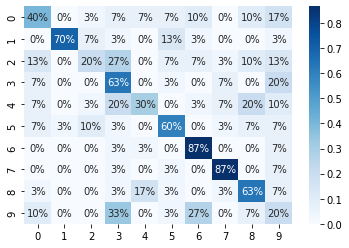

In [21]:
# SVC:

svc = SVC(random_state = 42)
grid = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

estimator = GridSearchCV(svc, param_grid=grid, cv = cv, scoring = 'accuracy')

start_time_train = time.time()
estimator.fit(pca_features_train, y_train) 
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = estimator.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = estimator.best_estimator_.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

print("\n" + 'Οι βέλτιστες υπερπαράμετροι είναι οι εξής: ' + str(estimator.best_params_))

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')

Train time = 0.356442928314209 s
Test time = 0.0010273456573486328 s

Accuracy: 0.47
Precision: 0.48809417273615996
Recall: 0.47000000000000003
F1 score: 0.474846895092926

Οι βέλτιστες υπερπαράμετροι είναι οι εξής: {'criterion': 'gini'}


<AxesSubplot:>

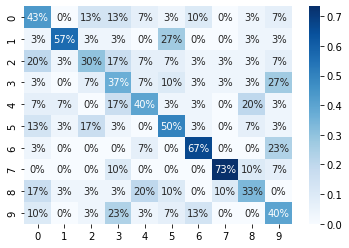

In [22]:
# Decision Tree:

dt = DecisionTreeClassifier(random_state=42)
grid = {"criterion": ['gini', 'entropy']}

estimator = GridSearchCV(dt, param_grid=grid, cv = cv, scoring = 'accuracy')

start_time_train = time.time()
estimator.fit(pca_features_train, y_train) 
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = estimator.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = estimator.best_estimator_.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

print("\n" + 'Οι βέλτιστες υπερπαράμετροι είναι οι εξής: ' + str(estimator.best_params_))

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver l

Train time = 0.49155092239379883 s
Test time = 0.00039958953857421875 s

Accuracy: 0.53
Precision: 0.5461772918456187
Recall: 0.53
F1 score: 0.5200892930727493

Οι βέλτιστες υπερπαράμετροι είναι οι εξής: {'penalty': 'l2'}


<AxesSubplot:>

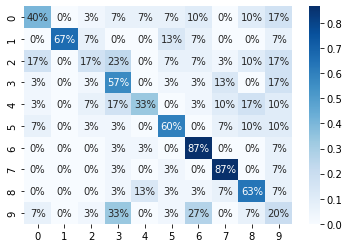

In [23]:
# Logistic Regression:

lr = LogisticRegression(random_state = 42)
grid = {"penalty": ['l1', 'l2', 'elasticnet']}

estimator = GridSearchCV(lr, param_grid=grid, cv = cv, scoring = 'accuracy')

start_time_train = time.time()
estimator.fit(pca_features_train, y_train) 
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = estimator.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = estimator.best_estimator_.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

print("\n" + 'Οι βέλτιστες υπερπαράμετροι είναι οι εξής: ' + str(estimator.best_params_))

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Train time = 34.4722855091095 s
Test time = 0.0022439956665039062 s

Accuracy: 0.55
Precision: 0.5502338095303337
Recall: 0.5499999999999999
F1 score: 0.5430434068575793

Οι βέλτιστες υπερπαράμετροι είναι οι εξής: {'hidden_layer_sizes': (30, 30)}


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

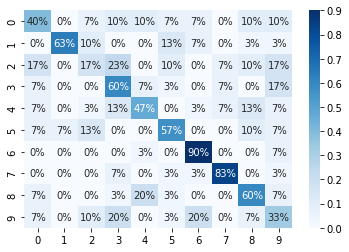

In [24]:
# MLP:

mlp = MLPClassifier(random_state = 42)
grid = {"hidden_layer_sizes": [(30,30), (50,50), (100, 100)]}

estimator = GridSearchCV(mlp, param_grid=grid, cv = cv, scoring = 'accuracy')

start_time_train = time.time()
estimator.fit(pca_features_train, y_train) 
print("Train time = " + str(time.time() - start_time_train) + " s")
start_time_test = time.time()
y_pred = estimator.predict(pca_features_test)
print("Test time = " + str(time.time() - start_time_test) + " s" + "\n")

accuracy = estimator.best_estimator_.score(pca_features_test, y_test)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

print("\n" + 'Οι βέλτιστες υπερπαράμετροι είναι οι εξής: ' + str(estimator.best_params_))

cm = confusion_matrix(y_test, y_pred)
norm_cm = [[0 for j in range(10)] for i in range(10)]
for i in range(10):
    for j in range(10):
      norm_cm[i][j] = cm[i][j] / sum(cm[i])

sns.heatmap(norm_cm, annot = True, fmt = '-1.0%', cmap = 'Blues')

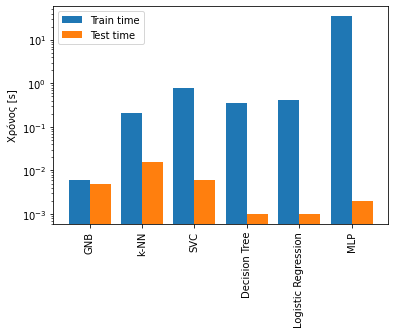

In [15]:
# Plotting train and test times:

clf = ['GNB','k-NN','SVC','Decision Tree','Logistic Regression','MLP']
train_time = [0.006,0.207,0.789,0.356,0.412,34.472]
test_time = [0.005,0.016,0.006,0.001,0.001,0.002]
  
clf_axis = np.arange(len(clf))
  
plt.bar(clf_axis - 0.2, train_time, 0.4, label = 'Train time')
plt.bar(clf_axis + 0.2, test_time, 0.4, label = 'Test time')

plt.xticks(clf_axis, clf)
plt.xticks(rotation=90)
plt.ylabel("Χρόνος [s]")
plt.yscale('log')   # add this line to make the y-axis logarithmic
plt.legend()
plt.show()